In [855]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Loading Data Set 1: GDSC 

Please note that before running the code, you will need all the GDSC files. They can be found on the drive (https://drive.google.com/drive/u/1/folders/11omvpOttkdZZgv_ppbtcCbojkuVR-D61) or directly on the GDSC website.

In [856]:
NB_DRUGS = 10 #number of best drugs to select
SCORE = "LN_IC50" #how the sensitivity of the drug is computed; other option: "AUC" 
SAVE = True #whether to save the final matrix or not
PATH = "data/" #where your data is located

#### Cell populations and labels

File which represents how well each cell population reacted to each drug. 

1. How is the drug measured?

    a. **IC50:** describes the concentration of an inhibitor that results in a half-maximal inhibition of a response (i.e. the concentration that reduces a response to 50% of its maximum). That maximum response being inhibited is due to the action of something else (typically an agonist for the receptor of interest). Maximum IC50 = 8. Minimum IC50 = 0. 
    
    IC50 is obtained by plotting a measure of the cell death rate vs the concentration of the drug. IC50 is expressed as a concentration so the higher the concentration of drug needed to kill the cell line the more resistant that cell line is. If the IC50 is very low then the concentration (or amount) of drug needed to kill the cell line is also very low which means the cell line is more sensitive. Typically you get a S curve or sigmoidal curve. IC50 is the middle point of the sigmoidal curve. The threshold for calling a drug sensitive/resistant changes depending upon the IC50 value and we need to see how the sigmoidal curve behaves.
    
    d.	**ActArea:** "*Sensitivity was assayed by measuring cellular ATP levels as a surrogate  for cell number and growth. Raw data were merged with assay metadata, and percent-viability scores were calculated relative to DMSO controls, after which concentration-response curves were fit for percent viability. The areas under percent-viability curves were computed and used as the measure of sensitivity*". In one paper, the limit was set to **0.8 SD**. Sensitive cell lines were the ones with an activity area at least 0.8 SD above the mean. Resistant cell lines had an activity area at least 0.8 SD below the mean. All other samples were discared.
    


In [861]:
conversion = pd.read_excel(PATH + "GDSC_CCLE_conversion.xlsx")[["GDSC1000 cosmic id","GDSC1000 name","CCLE name"]]
conversion.head()

,GDSC1000 cosmic id,GDSC1000 name,CCLE name
0,906800,697,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
1,687452,5637,5637_URINARY_TRACT
2,924100,22RV1,22RV1_PROSTATE
3,910924,23132-87,NaN
4,687561,42-MG-BA,42MGBA_CENTRAL_NERVOUS_SYSTEM


In [862]:
responses = pd.read_excel(PATH + "Fitted_dose_response.xlsx")
responses.head()

,DATASET_VERSION,IC50_RESULTS_ID,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,MAX_CONC_MICROMOLAR,MIN_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,Z_SCORE
0,17.3,1,683665,MC-CAR,1,Erlotinib,EGFR,2.0,0.007812,2.453524,0.982610,0.021678,-0.015505
1,17.3,1482,684055,ES3,1,Erlotinib,EGFR,2.0,0.007812,3.376592,0.985169,0.029915,0.779999
2,17.3,1791,684057,ES5,1,Erlotinib,EGFR,2.0,0.007812,3.614664,0.983207,0.031201,0.985170
3,17.3,2177,684059,ES7,1,Erlotinib,EGFR,2.0,0.007812,3.223394,0.984574,0.093857,0.647971
4,17.3,2754,684062,EW-11,1,Erlotinib,EGFR,2.0,0.007812,2.486405,0.946034,0.087280,0.012832


In [863]:
#Information about data set 

print("Number of different drugs: ",len(responses["DRUG_NAME"].unique()))
print("Number of different cell lines: ", len(responses["CELL_LINE_NAME"].unique()))
print("Total number of tests: ", len(responses.index))
print("Number of tests and cells per drug compounds:")
response_summary = responses.groupby(["DRUG_NAME"])["CELL_LINE_NAME"].agg(['count','nunique']).sort_values(["count"], ascending = False)
response_summary.rename(index = str, columns = {'count': "Number of tests", "nunique" : 'Number of unique cell populations'}, inplace = True)
display(response_summary)

Number of different drugs:  251
Number of different cell lines:  1065
Total number of tests:  224202
Number of tests and cells per drug compounds:


,Number of tests,Number of unique cell populations
DRUG_NAME,,
Avagacestat,1934,1043
UNC0638,1930,1038
AKT inhibitor VIII,1913,998
JQ1,1881,1040
CHIR-99021,1879,1040
AZD6482,1864,1038
Bicalutamide,1830,1034
Afatinib,1825,985
PLX-4720,1824,985


In [864]:
#Select drugs

selected_drugs = response_summary.index[:NB_DRUGS].values.tolist() #select the drugs
best_responses = responses[responses["DRUG_NAME"].isin(selected_drugs)] #filter the responses df to keep only the ones of selected drugs
best_responses = pd.merge(left = best_responses, right = conversion, how = 'left', left_on = 'COSMIC_ID', right_on = "GDSC1000 cosmic id") #add the corresponding CCLE names
best_responses = best_responses.drop(labels = ["DATASET_VERSION", "IC50_RESULTS_ID", "PUTATIVE_TARGET","MAX_CONC_MICROMOLAR", "MIN_CONC_MICROMOLAR", "RMSE", "Z_SCORE", "GDSC1000 cosmic id", "GDSC1000 name"], axis = 1)
best_responses.head()

,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,LN_IC50,AUC,CCLE name
0,683665,MC-CAR,150,Bicalutamide,1.922705,0.985136,NaN
1,683667,PFSK-1,150,Bicalutamide,2.736094,0.984795,NaN
2,684052,A673,150,Bicalutamide,2.145978,0.988013,A673_BONE
3,684055,ES3,150,Bicalutamide,2.693776,0.984989,NaN
4,684057,ES5,150,Bicalutamide,2.945234,0.983207,NaN


In [865]:
#Missing elements

print("Number of elements before dropping missing values", len(best_responses.index))
best_responses = best_responses.dropna(axis = 0)
print("Number of elements after dropping missing values", len(best_responses.index))
best_responses.head()

Number of elements before dropping missing values 18696
Number of elements after dropping missing values 7196


,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,LN_IC50,AUC,CCLE name
2,684052,A673,150,Bicalutamide,2.145978,0.988013,A673_BONE
7,684072,SK-ES-1,150,Bicalutamide,2.441425,0.980461,SKES1_BONE
10,687452,5637,150,Bicalutamide,2.294547,0.989483,5637_URINARY_TRACT
11,687455,RT4,150,Bicalutamide,2.910067,0.987345,RT4_URINARY_TRACT
12,687457,SW780,150,Bicalutamide,1.686112,0.959700,SW780_URINARY_TRACT


In [866]:
print('Percentage of Null Values in Each Column:')
for column in best_responses:
    print(column,(best_responses[column].isnull().sum())/len(best_responses)*100)

Percentage of Null Values in Each Column:
COSMIC_ID 0.0
CELL_LINE_NAME 0.0
DRUG_ID 0.0
DRUG_NAME 0.0
LN_IC50 0.0
AUC 0.0
CCLE name 0.0


In [867]:
final_response_matrix = best_responses.pivot_table(index = "CCLE name", columns = "DRUG_NAME", values = SCORE)
if SAVE:
    final_response_matrix.to_csv(PATH + 'final_response_matrix.csv')
final_response_matrix.head()

DRUG_NAME,AKT inhibitor VIII,AZD6482,Afatinib,Avagacestat,Bicalutamide,CHIR-99021,JQ1,Olaparib,PLX-4720,UNC0638
CCLE name,,,,,,,,,,
22RV1_PROSTATE,1.179495,3.191798,3.292738,3.669544,3.946671,3.615210,0.564080,4.378780,4.941684,1.804188
42MGBA_CENTRAL_NERVOUS_SYSTEM,2.560047,0.914375,3.222914,4.204779,3.703328,2.902907,1.430843,2.445944,4.973607,1.815938
5637_URINARY_TRACT,2.786479,2.929412,0.755066,4.129942,3.295490,3.352622,0.502312,2.520693,3.131749,3.185163
639V_URINARY_TRACT,2.761992,0.879081,1.705377,4.070210,3.118583,3.304297,-0.583141,2.276665,4.210108,3.568516
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.104100,1.056752,1.704682,3.337629,2.731476,1.954022,0.025710,0.910062,2.004732,1.417490


In [868]:
print("Total number of cell populations for each drug:")
display(final_response_matrix.count(axis = 0))

Total number of cell populations for each drug:


DRUG_NAME
AKT inhibitor VIII    372
AZD6482               385
Afatinib              378
Avagacestat           386
Bicalutamide          385
CHIR-99021            386
JQ1                   386
Olaparib              380
PLX-4720              378
UNC0638               385
dtype: int64

In [869]:
print("How many NaN values do we have per drug compound ?")
display(pd.DataFrame(final_response_matrix.isnull().sum(axis = 0)).T)
print("Total number of missing values: ", final_response_matrix.isnull().sum().sum())

How many NaN values do we have per drug compound ?


DRUG_NAME,AKT inhibitor VIII,AZD6482,Afatinib,Avagacestat,Bicalutamide,CHIR-99021,JQ1,Olaparib,PLX-4720,UNC0638
0,15,2,9,1,2,1,1,7,9,2


Total number of missing values:  49


There are also other datasets provided by GDSC.

In [870]:
drugs = pd.read_csv(PATH + "Drugs.csv") #provides information on the different drugs
drugs.head()

,drug_id,Name,Synonyms,Targets,Target pathway,PubCHEM,Sample Size,Count
0,1242,(5Z)-7-Oxozeaenol,"5Z-7-Oxozeaenol, LL-Z1640-2",TAK1,"Other, kinases",9863776,945,266
1,179,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,3385,968,266
2,86,A-443654,KIN001-139,"AKT1, AKT2, AKT3",PI3K/MTOR signaling,10172943,425,266
3,55,A-770041,KIN001-111,"LCK, FYN","Other, kinases",9549184,426,266
4,1001,AICA Ribonucleotide,"AICAR, N1-(b-D-Ribofuranosyl)-5-aminoimidazole...",AMPK agonist,Metabolism,65110,872,266


In [871]:
cells = pd.read_csv(PATH + "Cells.csv") #provides information on the different cell populations 
cells.head()

,,COSMIC_ID,Name,COSMIC_ID.1,Tissue,Tissue sub-type,Count
1287381,201T,SIDM00055,1287381,LUAD,lung,lung_NSCLC_adenocarcinoma,1065
924100,22RV1,SIDM00499,924100,PRAD,urogenital_system,prostate,1065
910924,23132-87,SIDM00980,910924,STAD,digestive_system,stomach,1065
687561,42-MG-BA,SIDM00982,687561,GBM,nervous_system,glioma,1065
1287706,451Lu,SIDM01240,1287706,SKCM,skin,melanoma,1065


In [872]:
features = pd.read_csv(PATH + "Features.csv") #provides information on the different types of alterations
features.head()

,feature_id,Name,Type,Known Driver Genes (cna only),Count
0,1,ABCB1_mut,coding variant,NaN,659
1,2,ABL2_mut,coding variant,NaN,659
2,3,ACACA_mut,coding variant,NaN,659
3,4,ACVR1B_mut,coding variant,NaN,659
4,5,ACVR2A_mut,coding variant,NaN,659


## Loading Data Set 2: Mutations

File which represents the presence of mutations in these same cell populations.

0 = mutation is not present

1 = mutation is present

In [873]:
alterations = pd.read_csv("data/Alterations.txt", sep  = '\t').set_index('Description').transpose()
alterations.head()

Description,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,HNRNPDL_del,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del
127399_SOFT_TISSUE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Merging Mutation and Drug Response Data

In [912]:
ML_matrix = alterations.merge(final_response_matrix[['Avagacestat']], left_index = True, right_index = True).dropna(axis = 0)
ML_matrix.head()

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Avagacestat
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.669544
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.253932
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.100926
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.382341
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.998315


Quick look at the distribution.

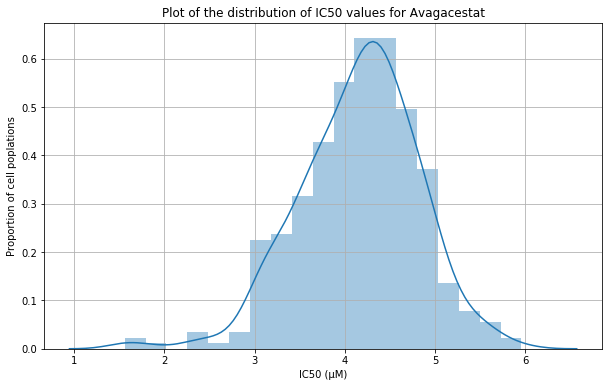

In [913]:
fig = plt.figure(figsize = (10,6))
sns.distplot(ML_matrix[["Avagacestat"]])
plt.title("Plot of the distribution of IC50 values for Avagacestat")
plt.xlabel("IC50 (µM)")
plt.ylabel("Proportion of cell poplations")
plt.grid(True);

### Categorization of Resistant vs. Sensitive 

Everything that's above the mean + 0.5 $\times$ the standard deviation (high IC50) is classified as "resistant" wheras eveything below the mean - 0.5 $\times$ the standard deviation is classified at "sensitive". Everything that is in the middle is discarded.

In [914]:
print("The lower threshold used here is the mean minus half the standard deviation = ", np.mean(ML_matrix["Avagacestat"])-0.75*np.std(ML_matrix["Avagacestat"]))
print("The upper threshold used here is the mean plus half the standard deviation = ", np.mean(ML_matrix["Avagacestat"])+ 0.57*np.std(ML_matrix["Avagacestat"]))
ML_matrix["Response"] = pd.cut(ML_matrix["Avagacestat"], [np.min(ML_matrix["Avagacestat"]), np.mean(ML_matrix["Avagacestat"]) - 0.75*np.std(ML_matrix["Avagacestat"]), np.mean(ML_matrix["Avagacestat"]) + 0.75*np.std(ML_matrix["Avagacestat"]), np.max(ML_matrix["Avagacestat"])], labels = ["sensitive","medium", "resistant"])
ML_matrix = ML_matrix.drop(["Avagacestat"], axis = 1)
ML_matrix.head()

The lower threshold used here is the mean minus half the standard deviation =  3.6630822478860416
The upper threshold used here is the mean plus half the standard deviation =  4.530488434896425


,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,sensitive


In [915]:
#Drop all the "medium" classes; they are not needed for the purpose of our project
ML_matrix = ML_matrix.drop(ML_matrix[ML_matrix["Response"] == "medium"].index) 
ML_matrix.head()

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,sensitive
CORL23_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive


In [916]:
# Looking at class balance
print("Number of resistant cells: ", len(ML_matrix[ML_matrix["Response"] == "resistant"]))
print("Number of sensitive cells: ", len(ML_matrix[ML_matrix["Response"] == "sensitive"]))
print("Total number of cells: ", len(ML_matrix.index))

Number of resistant cells:  83
Number of sensitive cells:  83
Total number of cells:  167


We see that our classes are more or less equal (which is good!). 

### Feature Selection Using PCA

Number of features before PCA:  64144


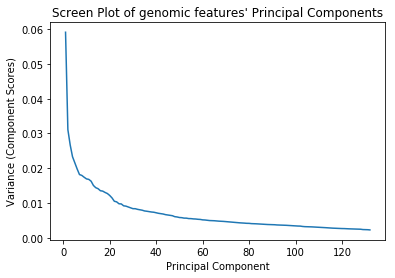

Number of combined features after PCA:  132


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131
0,-2.951572,-2.863156,-0.789620,0.008603,0.208918,0.304542,-1.259532,0.454552,-0.083356,-0.490797,...,-0.426229,-0.701644,-0.081269,-0.712827,0.689172,-0.490417,0.190349,-0.682450,0.049179,-0.039583
1,-2.936174,-2.938205,-0.379784,0.001858,0.140703,0.086724,-0.857692,1.594134,-0.556957,-0.040098,...,-1.311525,-0.196109,-0.166150,-1.324357,0.297087,-0.829415,0.903130,-1.886517,0.256034,0.226148
2,-1.065368,-2.392186,-1.735033,0.006454,0.211801,4.792075,10.830422,-3.099975,-0.864272,4.378676,...,-0.233847,-0.293715,0.563868,0.427600,0.097059,0.279905,0.321795,0.308848,-0.178338,0.253049
3,5.370317,-2.459522,-0.689941,0.118967,0.713984,-0.884379,-1.459830,-0.008956,0.240868,-0.710272,...,-0.058091,0.216968,0.050005,0.060215,0.147091,0.121883,-0.022668,-0.191434,0.013020,-0.037750
4,-3.774103,-3.895381,-3.094681,-0.195294,0.118053,8.633769,18.322811,-4.798611,-4.385370,6.532658,...,0.375747,0.707683,1.498457,0.769203,-0.331115,0.085397,1.095901,0.475023,0.894868,0.843929


In [917]:
from sklearn.decomposition import PCA

X = ML_matrix.drop("Response", axis = 1)
y = ML_matrix["Response"].astype(str)

NB_COMPONENTS = 132
screeplot = True

print("Number of features before PCA: ", len(ML_matrix.columns) - 1)


my_PCA = PCA(n_components=NB_COMPONENTS)
reduced_X = pd.DataFrame(my_PCA.fit_transform(np.array(X.values), y=None))
reduced_X.columns = [f"PC{elem}" for elem in range(NB_COMPONENTS)]

if screeplot:
    fig = plt.figure()
    g = sns.lineplot(x = range(1,NB_COMPONENTS+1), y = my_PCA.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance (Component Scores)')
    plt.title('Screen Plot of genomic features\' Principal Components')
    plt.show(); 


print("Number of combined features after PCA: ",len(list(reduced_X)))
reduced_X.head()

### Fitting to PCA-Selected Data: Random Forest

In [918]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.1, random_state=32)

#Scaling the features -- useful for most classifier except RF and co
        
feature_names = list(reduced_X) #stores the name of features, same for both training and validation

sc = StandardScaler()  #defines the scaler
X_train = pd.DataFrame(sc.fit_transform(X_train))  #scales the training data
X_test = pd.DataFrame(sc.transform(X_test))  #scales the validation data


#Replace feature names in the database (they are lost during scaling)
X_train.columns = feature_names
X_test.columns = feature_names    


#clf = RandomForestClassifier(n_estimators=300, max_depth = 5, max_leaf_nodes = 10, random_state=0)
random_forest = MLPClassifier(alpha = 1e-5, random_state = 0)
random_forest.fit(X_train.values.tolist(), y_train.values)

acc_rf_train = random_forest.score(X_train, y_train)           # predict + evaluate (training)
acc_rf_test = random_forest.score(X_test, y_test)              # predict + evaluate (test)
print('Random Forest Training Labeling Accuracy:', str(round(acc_rf_train*100,3)),'%')
print('Random Forest Test Labeling Accuracy:', str(round(acc_rf_test*100,3)),'%')

Random Forest Training Labeling Accuracy: 100.0 %
Random Forest Test Labeling Accuracy: 64.706 %


### Fitting to PCA-Selected Data: Logistic Regression

In [919]:
from sklearn.feature_selection import RFE
logreg = LogisticRegression(solver= 'saga',multi_class='ovr', max_iter=5000) #instantiate                            
logreg.fit(X_train, y_train) #fit                              

acc_logreg_train = logreg.score(X_train, y_train)  # predict + evaluate (training) 
acc_logreg_test = logreg.score(X_test, y_test)     # predict + evaluate (training) 
 
print('Logistic Regression Training Labeling Accuracy:', str(round(acc_logreg_train,3)*100),'%')             
print('Logistic Regression Test Labeling Accuracy:', str(round(acc_logreg_test,3)*100),'%')

Logistic Regression Training Labeling Accuracy: 95.3 %
Logistic Regression Test Labeling Accuracy: 76.5 %


### Fitting to PCA-Selected Data: K-Nearest Neighbors

In [920]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)            # instantiate               
knn.fit(X_train, y_train)                              # fit                                   
acc_knn_train = knn.score(X_train, y_train)            # predict + evaluate (training)                    
acc_knn_test = knn.score(X_test, y_test)               # predict + evaluate (test)

print('KNN Training Labeling Accuracy:', str(round(acc_knn_train*100,3)),'%')
print('KNN Test Labeling Accuracy:', str(round(acc_knn_test*100,3)),'%')

KNN Training Labeling Accuracy: 73.333 %
KNN Test Labeling Accuracy: 41.176 %


### Fitting to PCA-Selected Data: Perceptron

In [921]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(max_iter=5000, tol=None)              # instantiate                                  
perceptron.fit(X_train, y_train)                              # fit                          
acc_perceptron_train = perceptron.score(X_train, y_train)     # predict + evaluate (training)
acc_perceptron_test = perceptron.score(X_test, y_test)        # predict + evaluate (test)

print('Perceptron Training Labeling Accuracy:', str(round(acc_perceptron_train*100,3)),'%')
print('Perceptron Test Labeling Accuracy:', str(round(acc_perceptron_test*100,3)),'%')


Perceptron Training Labeling Accuracy: 100.0 %
Perceptron Test Labeling Accuracy: 70.588 %


### Fitting to PCA-Selected Data: Ridge Regression

In [922]:
from sklearn.linear_model import Ridge

ridgereg = LogisticRegression(solver= 'lbfgs',multi_class='ovr', max_iter=5000) #instantiate                            
ridgereg.fit(X_train, y_train)                                                  #fit                              

acc_ridgereg_train = ridgereg.score(X_train, y_train)                           # predict + evaluate (training) 
acc_ridgereg_test = ridgereg.score(X_test, y_test)                              # predict + evaluate (training) 
 
print('Ridge Regression Training Labeling Accuracy:', str(round(acc_ridgereg_train,3)*100),'%')             
print('Ridge Regression Test Labeling Accuracy:', str(round(acc_ridgereg_test,3)*100),'%')

Ridge Regression Training Labeling Accuracy: 95.3 %
Ridge Regression Test Labeling Accuracy: 76.5 %


### Evaluation of Machine Learning Models with PCA-Selected Data

In [923]:
#displays dataframe with test accuracies from each machine learning model

d = {'Machine Learning Model':['Logistic Regression', 'KNN', 'Perceptron', 'Random Forest', 'Support Vector', 'Ridge Regression'], \
        'Test Accuracy (Percent)': [round(acc_logreg_test*100,3),round(acc_knn_test*100,3), round(acc_perceptron_test*100,3), \
                                    round(acc_rf_test*100,3),round(acc_clf_test*100,3), round(acc_ridgereg_test*100,3)]}
print()
print('Baseline: 50%')
display(pd.DataFrame(data=d))


Baseline: 50%


,Machine Learning Model,Test Accuracy (Percent)
0,Logistic Regression,76.471
1,KNN,41.176
2,Perceptron,70.588
3,Random Forest,64.706
4,Support Vector,50.000
5,Ridge Regression,76.471


###  Recursive Feature Selection

We're going to try a different method of feature selection, then re-fit the data to each of the models. 

In [924]:
#changing last column to 0,1 values
ML_matrix['Response'] = [0 if x=='resistant' else 1 for x in ML_matrix['Response']]
ML_matrix.head()

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
CORL23_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [925]:
def scale_data(X_train, X_test):
    
    feature_names = list(X_train) # Store the feature names
    
    sc = StandardScaler()  #defines the scaler
    X_train = pd.DataFrame(sc.fit_transform(X_train))  #scales the training data
    X_test = pd.DataFrame(sc.transform(X_test))  #scales the validation data

    #Replace feature names in the database (they are lost during scaling)
    X_train.columns = feature_names
    X_test.columns = feature_names
    
    return X_train, X_test

In [926]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

def run_model(X, y, model, n_splits = 3):
    count = 0 
    
    train_accuracies, val_accuracies, rocs = [],[],[]

    # Define a cross-validation (shuffleSplit here)
    ss = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

    for count, (training_indices, val_indices) in enumerate(ss.split(X, y), 1):

        print(f'Cross-validation: {count}/{n_splits}')

        # Prepare the test and training set     
        X_train = X.iloc[training_indices,:]#.sample(frac=1, random_state = 6)
        y_train = y.iloc[training_indices]#.sample(frac=1, random_state = 6)
        X_val = X.iloc[val_indices,:]#.sample(frac=1, random_state = 6)
        y_val = y.iloc[val_indices]#.sample(frac=1, random_state = 6)
        
        print(f"The validation set corresponds to roughly {np.round(100*(len(X_val.index)/len(X.index)),2)}% of the total data.") 
        
        #Scaling the features -- useful for most classifier except RF and co
        X_train, X_val = scale_data(X_train, X_val)
        
        selector = RFE(model)
        X_train = pd.DataFrame(selector.fit_transform(X_train, y_train))
        X_val = pd.DataFrame(selector.transform(X_val))

        
        # Define the classifier
        clf = model
        
        # Fit the classifier
        clf.fit(X_train.values.tolist(), y_train.values)        
        
        # Predict the classes
        y_pred = clf.predict(X_val.values.tolist())
        
        # Calculate the performance metrics 
        train_acc = accuracy_score(y_train.values.tolist(), clf.predict(X_train.values.tolist()))
        val_acc = accuracy_score(y_val.values.tolist(), y_pred)
        #roc_auc = roc_auc_score(y_val.values, clf.predict_proba(X_val.values)[:, 1])
        
        print(f"Training accuracy {count}: {train_acc}")
        print(f"Validation accuracy {count}: {val_acc}")
        #print(f"ROC AUC {count}: {roc_auc}")
    
        # Add the performances to their corresponding lists
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        #rocs.append(roc_auc)
    print("_________________________________________________________________________________")   
    print(f'Average Training Accuracy of {model_names[i]} {np.round(100*np.mean(train_accuracies), 2)} +/- {np.round(100*np.std(train_accuracies),2)}%.')
    print(f'Average Validation Accuracy of {model_names[i]} {np.round(100*np.mean(val_accuracies),2)} +/- {np.round(100*np.std(val_accuracies),2)}%.')
    #print(f'Average area under the curve {np.round(100*np.mean(np.array(rocs)),2)} +/- {np.round(100*np.std(np.array(rocs)),2)}%.')
    
    return 100*np.mean(train_accuracies), 100*np.std(train_accuracies), 100*np.mean(val_accuracies), 100*np.std(val_accuracies), 100*np.mean(np.array(rocs)), 100*np.std(np.array(rocs))

N_SPLITS = 3

X = ML_matrix.drop("Response", axis = 1)
y = ML_matrix["Response"].astype('float64')

models = [logreg, perceptron, ridgereg]
model_names = ['Logistic Regression','Perceptron', 'Ridge Regression']

for i in range(len(models)):
    print('Running',model_names[i],'Recursive Feature Selection')
    print('______________________')
    print()
    performances = run_model(reduced_X, y, models[i], n_splits = N_SPLITS)
    print()

Running Logistic Regression Recursive Feature Selection
______________________

Cross-validation: 1/3
The validation set corresponds to roughly 20.36% of the total data.
Training accuracy 1: 0.9624060150375939
Validation accuracy 1: 0.47058823529411764
Cross-validation: 2/3
The validation set corresponds to roughly 20.36% of the total data.
Training accuracy 2: 0.9624060150375939
Validation accuracy 2: 0.4411764705882353
Cross-validation: 3/3
The validation set corresponds to roughly 20.36% of the total data.
Training accuracy 3: 0.9548872180451128
Validation accuracy 3: 0.29411764705882354
_________________________________________________________________________________
Average Training Accuracy of Logistic Regression 95.99 +/- 0.35%.
Average Validation Accuracy of Logistic Regression 40.2 +/- 7.72%.

Running Perceptron Recursive Feature Selection
______________________

Cross-validation: 1/3
The validation set corresponds to roughly 20.36% of the total data.
Training accuracy 1: 1.0


### Major Takeaways

### Next Steps

- The GDSC portal provides a list of 659 features that are frequently altered in cancer and are correlated with drug sensitivity. We will use these to add different weights to features.
- Include Pearson's coefficient in feature selection.
- Develop user interface.